## Topologic Distances
### Testing various distance metrics on scalar fields and reeb graph decompositions

In [1]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csd_functions
import scipy
import networkx as nx
import reeb_matching
from copy import deepcopy
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster
import random
from scipy.spatial.distance import directed_hausdorff
from sklearn.manifold import TSNE
sns.set()


In [2]:
prefix = 'gbarEvPyrAmpa_sweep'

data_dir = os.path.abspath('../lfp_reeb_github/data')
name = ['gbarEvPyrAmpa_sweep10','gbarEvPyrAmpa_sweep9']

R_points, _ = reeb_matching.load_tree(data_dir,prefix,name[0])
S_points, _ = reeb_matching.load_tree(data_dir,prefix,name[1])

In [3]:
def csd_sim_matrix(file_list, data_dir, prefix):
    num_files = len(file_list)
    similarity_matrix = np.empty((num_files,num_files))
    for csd_row in range(num_files):
        for csd_col in range(num_files):
                R_path = data_dir[csd_row] + '/' + prefix[csd_row] + '/points/' + file_list[csd_row]
                S_path = data_dir[csd_col] + '/' + prefix[csd_col] + '/points/' + file_list[csd_col]
                
                R_points, S_points = np.array(pd.read_csv(R_path)), np.array(pd.read_csv(S_path)) 
                Y1, Y2 = csd_functions.points2grid(R_points), csd_functions.points2grid(S_points)

                similarity = max(directed_hausdorff(R_points, S_points)[0], directed_hausdorff(S_points, R_points)[0])

                similarity_matrix[csd_row,csd_col] = similarity
                print(csd_row,csd_col,'w_sim = ', similarity)

def reeb_sim_matrix(file_list, data_dir, prefix):
    num_files = len(file_list)
    similarity_matrix = np.empty((num_files,num_files))

    for tree_row in range(num_files):
        for tree_col in range(num_files):
                R_points, _ = reeb_matching.load_tree(data_dir[tree_row],prefix[tree_row],file_list[tree_row])
                # R = reeb_matching.make_graph(R_points,R_connectivity)

                S_points, _ = reeb_matching.load_tree(data_dir[tree_col],prefix[tree_col],file_list[tree_col])
                # S = reeb_matching.make_graph(S_points,S_connectivity)

                similarity = max(directed_hausdorff(R_points,S_points)[0], directed_hausdorff(S_points,R_points)[0])
                similarity_matrix[tree_row,tree_col] = similarity

                print(tree_row,tree_col,'tree_sim = ', similarity)
                # print(MPAIR)

    return similarity_matrix



In [4]:
#Files to operate on
prefix = ['gbarEvPyrAmpa_sweep','gbarEvPyrAmpa_reversed_inputs']

flist1 = reeb_matching.get_skeleton_names(data_dir + '/' + prefix[0] + '/' + 'skeleton/') 
flist2 = reeb_matching.get_skeleton_names(data_dir + '/' + prefix[1] + '/' + 'skeleton/')
file_list = np.concatenate([flist1,flist2])

data_dir_array = np.repeat(data_dir, len(file_list))
prefix_array = np.repeat(prefix, [len(flist1), len(flist2)])
similarity_matrix = reeb_sim_matrix(file_list, data_dir_array, prefix_array)

0 0 tree_sim =  0.0
0 1 tree_sim =  118.00000252627791
0 2 tree_sim =  100.07996998400782
0 3 tree_sim =  109.04132129874966
0 4 tree_sim =  94.93682583004126
0 5 tree_sim =  101.41504369225731
0 6 tree_sim =  99.08077845910582
0 7 tree_sim =  94.0000000245219
0 8 tree_sim =  118.96218271260284
0 9 tree_sim =  118.00000095200727
0 10 tree_sim =  93.00002364107552
0 11 tree_sim =  104.00000060985363
0 12 tree_sim =  63.00000041675893
0 13 tree_sim =  116.00000199429061
0 14 tree_sim =  119.64118329444715
0 15 tree_sim =  107.00000003942527
0 16 tree_sim =  104.00000060985363
0 17 tree_sim =  106.36729022268922
0 18 tree_sim =  108.11567951684943
0 19 tree_sim =  118.00000088019614
0 20 tree_sim =  113.71895220963506
0 21 tree_sim =  105.39460191468368
0 22 tree_sim =  60.00000905696958
0 23 tree_sim =  70.00714421838002
0 24 tree_sim =  86.00001900749497
0 25 tree_sim =  113.0000000000021
0 26 tree_sim =  69.00724809540435
0 27 tree_sim =  73.43707414152541
0 28 tree_sim =  69.857002850

In [5]:

#Make symmetric wrt upper triangle
i_lower = np.tril_indices(similarity_matrix.shape[0], -1)
similarity_matrix[i_lower] = similarity_matrix.T[i_lower]



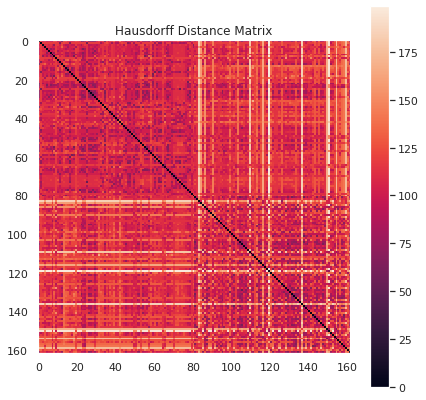

<function matplotlib.pyplot.legend(*args, **kwargs)>

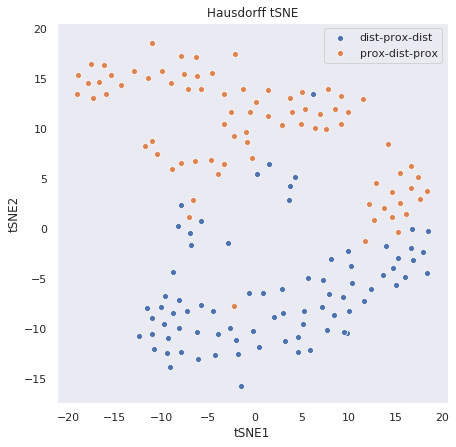

In [8]:
%matplotlib inline
plt.figure(figsize=(7,7))
sns.set_style('darkgrid',{'axes.grid' : False})
plt.imshow(similarity_matrix)
plt.title('Hausdorff Distance Matrix')
plt.colorbar()
plt.show()

plt.figure(figsize=(7,7))
sim_embedded = TSNE(n_components=2).fit_transform(similarity_matrix)
sns.scatterplot(x = sim_embedded[:82,0], y = sim_embedded[:82,1], label='dist-prox-dist')
sns.scatterplot(x = sim_embedded[82:,0], y = sim_embedded[82:,1], label='prox-dist-prox')
plt.title('Hausdorff tSNE')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.legend

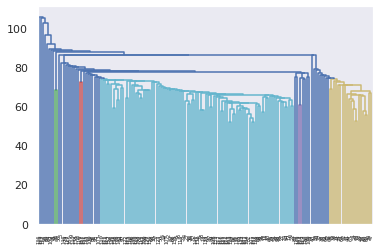

In [7]:
%matplotlib qt
# for i in range(similarity_matrix.shape[0]):
#     similarity_matrix[i,i] = 0

distVec = ssd.squareform(similarity_matrix)
linkage = hcluster.linkage(distVec)
plt.figure()
dendro  = hcluster.dendrogram(linkage)

In [12]:
%matplotlib inline
cluster_indeces = hcluster.fcluster(linkage, t=8, criterion='maxclust')
# cluster_indeces = hcluster.fcluster(linkage, t=1.153, criterion='inconsistent')

cluster_labels = np.unique(cluster_indeces)
p_dir = ['../lfp_reeb_github/data/gbarEvPyrAmpa_sweep/points', '../lfp_reeb_github/data/gbarEvPyrAmpa_reversed_inputs/points']
flist1, flist2 = np.array(os.listdir(p_dir[0])), np.array(os.listdir(p_dir[1]))
p_dir_array = np.repeat(p_dir, [len(flist1),len(flist2)])
file_list = np.concatenate([flist1,flist2])

num_selection = 4

cluster_labels


array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

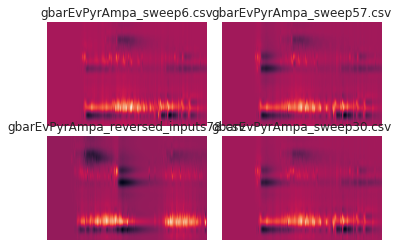

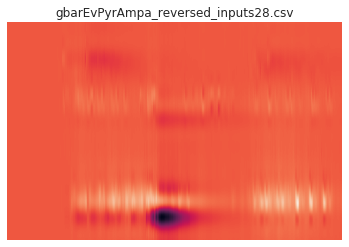

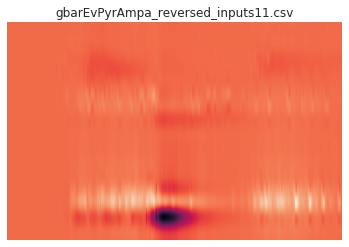

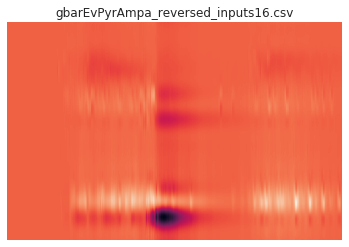

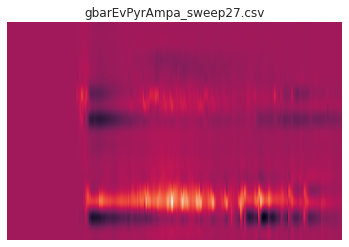

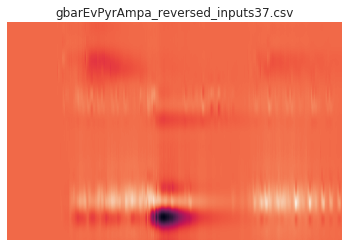

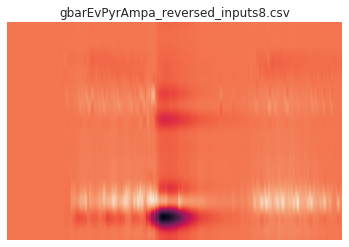

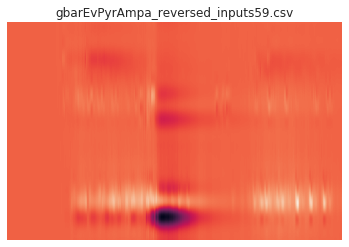

In [13]:
for label in cluster_labels:
    file_cluster = file_list[cluster_indeces == label]
    file_indeces = np.nonzero(cluster_indeces == label)[0]

    num_files = len(file_cluster)
    if num_files < num_selection:
        num_selection = num_files

    rand_choice = random.sample(np.arange(np.size(file_cluster)).tolist(), num_selection)

    num_rc = np.ceil(np.sqrt(num_selection)).astype(int)

    count = 1
    plt.figure()
    # for f in range(np.size(file_cluster)):
    for f in rand_choice:
        f_path = p_dir_array[file_indeces[f]] + '/' + file_cluster[f]

        plt.subplot(num_rc,num_rc,count)
        csd_grid = csd_functions.points2grid(np.array(pd.read_csv(f_path)))
        plt.imshow(csd_grid,aspect='auto')
        plt.axis('off')
        plt.title(file_cluster[f])
        
        count += 1
    
    # plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()